# Medical Insurance Cost Prediction

## 1. Load Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, PowerTransformer, OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings

## 2. Data Collection

In [2]:
df = pd.read_csv('insurance_engineered.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges,obesity,smoker_obese,age_cat
0,19,female,27.900,0,yes,southwest,9.734236,0,0,1
1,18,male,33.770,1,no,southeast,7.453882,0,0,1
2,28,male,33.000,3,no,southeast,8.400763,0,0,1
3,33,male,22.705,0,no,northwest,9.998137,0,0,2
4,32,male,28.880,0,no,northwest,8.260455,0,0,2


In [3]:
df.shape

(1337, 10)

In [4]:
print(df['charges'].value_counts())

charges
9.734236     1
7.658387     1
7.706417     1
9.893389     1
9.477683     1
            ..
8.901923     1
10.170086    1
10.250225    1
7.047861     1
10.279948    1
Name: count, Length: 1337, dtype: int64


## 3. Preparing Features (X) and Target (y):

In [5]:
# Separate features (X) and target (y)
X = df.drop(columns=['charges'], axis=1)
y = df['charges']

In [6]:
X.head()

,age,sex,bmi,children,smoker,region,obesity,smoker_obese,age_cat
0,19,female,27.900,0,yes,southwest,0,0,1
1,18,male,33.770,1,no,southeast,0,0,1
2,28,male,33.000,3,no,southeast,0,0,1
3,33,male,22.705,0,no,northwest,0,0,2
4,32,male,28.880,0,no,northwest,0,0,2


In [7]:
y.head()

0    9.734236
1    7.453882
2    8.400763
3    9.998137
4    8.260455
Name: charges, dtype: float64

## 4. Splitting Data

##### Train-Test Data Split:

In [8]:
# Split the Original Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 5. Transformation Pipeline

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

num_features = ['age', 'bmi', 'children', 'obesity', 'smoker_obese']
cat_features = ['sex', 'smoker', 'region']

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

transformer = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


### 6. Model Training and Evaluation

##### Models to Train and Evaluate:

In [10]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

##### Hyperparameter Tuning:

In [11]:
params = {
    'Linear Regression' : {},
    'Lasso' : {
        'regressor__alpha': [0.01, 0.1, 1.0, 5.0, 10.0]
    },
    
    'Ridge' : {
        'regressor__alpha': [0.01, 0.1, 1.0, 5.0, 10.0]
    },
    
    'K-Neighbors Regressor' : {
        'regressor__n_neighbors': [3, 5, 7],
        'regressor__weights': ['uniform', 'distance'],
        'regressor__p': [1, 2]
    },
    
    'Decision Tree' : {
        'regressor__criterion': ['squared_error', 'friedman_mse'],
        'regressor__max_depth': [3, 5, 7],
        'regressor__min_samples_split': [2, 5, 10]
    },

    'Random Forest Regressor' : {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_features': [None, 'sqrt', 'log2'],
        'regressor__max_depth': [None, 10, 20]
    },
    
    'XGBRegressor' : {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7]
    },
    'CatBoosting Regressor' : {
        'regressor__depth': [4, 6, 8],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__iterations': [100, 500]
    },
    
    'AdaBoost Regressor' : {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.1, 1.0],
        'regressor__loss': ['linear', 'square', 'exponential']
    }
}



##### Train and Evaluation:

In [12]:
# Evaluation loop: Iteratively train and evaluate each model
best_score = 0 
best_model_item = None
best_name = None
results= {}

for name in models.keys():

    mlops_pipeline = Pipeline(steps=[('transformer', transformer),('regressor',models[name])])
    
    gs = GridSearchCV(mlops_pipeline, params[name],cv=3)
    gs.fit(X_train, y_train)

    current_best_model = gs.best_estimator_

    X_ts_pred = current_best_model.predict(X_test)
    
    mae = mean_absolute_error(y_test,X_ts_pred)
    mse = mean_squared_error(y_test,X_ts_pred)
    rmse = np.sqrt(mean_squared_error(y_test,X_ts_pred))
    r2_square = r2_score(y_test,X_ts_pred)

    results[name] = r2_square

    if r2_square > best_score:
        best_score = r2_square
        best_model_item = current_best_model
        best_name= name 

    print(name)
    print("Test Set R2 Score: {:.4f}".format(r2_square))
    print("Test Set Root Mean Squared Error: {:.4f}".format(rmse))
    print("Test Set Mean Absolute Error: {:.4f}".format(mae))

Linear Regression
Test Set R2 Score: 0.8305
Test Set Root Mean Squared Error: 0.3965
Test Set Mean Absolute Error: 0.2647
Lasso
Test Set R2 Score: 0.8195
Test Set Root Mean Squared Error: 0.4093
Test Set Mean Absolute Error: 0.2684
Ridge
Test Set R2 Score: 0.8305
Test Set Root Mean Squared Error: 0.3965
Test Set Mean Absolute Error: 0.2647
K-Neighbors Regressor
Test Set R2 Score: 0.7611
Test Set Root Mean Squared Error: 0.4708
Test Set Mean Absolute Error: 0.3001
Decision Tree
Test Set R2 Score: 0.8709
Test Set Root Mean Squared Error: 0.3461
Test Set Mean Absolute Error: 0.1939
Random Forest Regressor
Test Set R2 Score: 0.8690
Test Set Root Mean Squared Error: 0.3486
Test Set Mean Absolute Error: 0.2046
XGBRegressor
Test Set R2 Score: 0.8835
Test Set Root Mean Squared Error: 0.3287
Test Set Mean Absolute Error: 0.1827
CatBoosting Regressor
Test Set R2 Score: 0.8786
Test Set Root Mean Squared Error: 0.3356
Test Set Mean Absolute Error: 0.1960
AdaBoost Regressor
Test Set R2 Score: 0.856

### 7. Best Performing Model Selection

In [13]:
# Find the best model
print(f"\n🏆 Best Model: {best_name} with {best_score:.4f} R2-Score and  {rmse:.4f} RMSE")


🏆 Best Model: XGBRegressor with 0.8835 R2-Score and  0.3649 RMSE


### 8. Final Evaluation with the Best Model

In [14]:
# Final Evaluation with the Best Model

f_preds = best_model_item.predict(X_test)
r2_square = r2_score(y_test, f_preds)

print(f"Final Evaluation on Test Set for {best_name}")
print(f"R2 Score: {r2_square:.4f}")

Final Evaluation on Test Set for XGBRegressor
R2 Score: 0.8835


### 9. Results Analysis Visualization

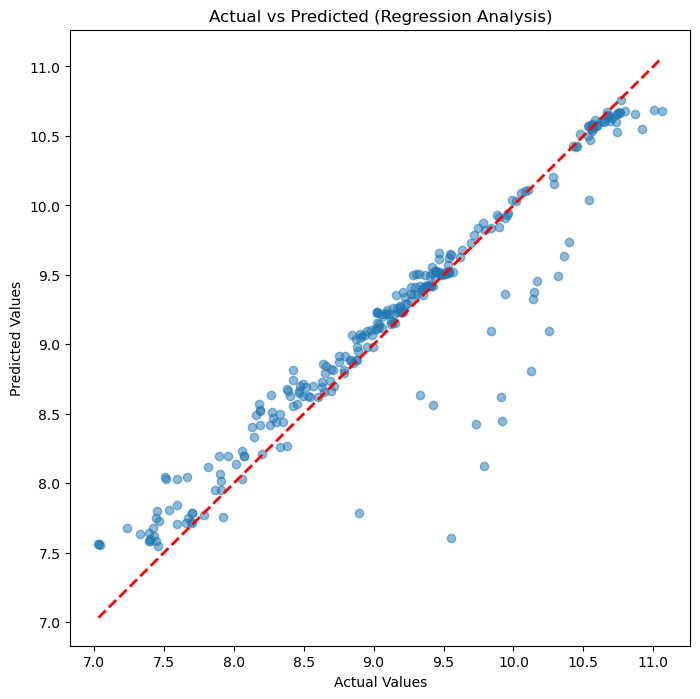

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(y_test, f_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) 
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Regression Analysis)')
plt.show()


In [16]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':f_preds,'Difference':y_test-f_preds})
pred_df

,Actual Value,Predicted Value,Difference
899,9.069912,9.205904,-0.135992
1063,8.649951,8.792153,-0.142202
1255,9.344674,9.392713,-0.048039
298,10.564818,10.584451,-0.019633
237,8.403846,8.631262,-0.227415
...,...,...,...
534,9.534748,9.522175,0.012574
542,9.538795,9.529519,0.009276
759,8.275569,8.510386,-0.234817
1283,10.766480,10.757780,0.008700
